# Reconnaissance et detection des personnages dans les Simpsons en utilisant les méthodes de réseaux de neurones artificiels

**Pierre-Edouard GUERIN**

18/12/2019
__________________

# Introduction


## Contexte

Un jeu de donnée complet d'images annotées des personnages de la série animé les Simpsons est disponible ici : https://www.kaggle.com/alexattia/the-simpsons-characters-dataset

En apprentissage automatique, un réseau de neurones convolutifs (CNN) est un type de réseau de neurones artificiels, dans lequel le motif de connexion entre les neurones est inspiré par le cortex visuel des animaux. L'idée est d'utiliser cette méthode pour créer un programme capable de detecter les différents personnages dans une video des Simpsons et de quantifier leur temps de présence pendant la video.


## Mission

L'objectif est de


## Script

a finir

# Prérequis

In [1]:
import os
import random
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
import scipy
import cv2
%matplotlib inline

np.random.seed(2)

from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import model_from_json


from skimage.transform import resize
from skimage import data

import warnings

warnings.filterwarnings('ignore')

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

# Charger, formater et explorer le jeu de données

In [2]:
## prepare data
dict_characters = {0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson', 
        3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
        7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lenny_leonard', 11:'lisa_simpson',
        12: 'marge_simpson', 13: 'mayor_quimby',14:'milhouse_van_houten', 15: 'moe_szyslak', 
        16: 'ned_flanders', 17: 'nelson_muntz', 18: 'principal_skinner', 19: 'sideshow_bob'}

In [3]:
def load_train_set(dirname,dict_characters):
    """load train data"""
    X_train = []
    Y_train = []
    for label, character in dict_characters.items():
        list_images = os.listdir(dirname+'/'+character)
        for image_name in list_images:
            image =  plt.imread(dirname+'/'+character+'/'+image_name)            
            X_train.append(resize(image,(64,64)))
            Y_train.append(label)
    return np.array(X_train), np.array(Y_train)

In [4]:
def load_test_set(dirname,dict_characters):
    """load test data"""
    X_test = []
    Y_test = []
    for image_name in os.listdir(dirname):
        character_name = "_".join(image_name.split('_')[:-1])
        label = [label for label,character in dict_characters.items() if character == character_name][0]
        image = plt.imread(dirname+'/'+image_name)
        X_test.append(resize(image,(64,64)))
        Y_test.append(label)
    return np.array(X_test), np.array(Y_test)

In [5]:
## load train data
X_train, Y_train = load_train_set("data/simpsons_characters_recognition_detection/the-simpsons-characters-dataset/simpsons_dataset/", dict_characters)       


In [6]:
## load test data
X_test, Y_test = load_test_set("data/simpsons_characters_recognition_detection/the-simpsons-characters-dataset/kaggle_simpson_testset/", dict_characters)

## Normalisation des images

Afin d'atténuer la contribution de la variation de la luminosité sur les différentes images à mon modèle CNN (nous voulons un modèle capable de reconnaître un personnage et non une valeur de luminosité), je dois convertir les images en niveaux de gris.

La couleur affichée sur chaque pixel d'une image est codée selon 3 valeurs allant de 0 à 255 : rouge, vert et bleue. Pour normaliser la variation des couleurs, je divise par 255 la valeur maximale. 


In [7]:
## Scale data
X_train = X_train / 255.0
X_test = X_test / 255.0

## Afficher les images

Voici deux fonctions pour afficher 20 images et leur personnage associé au hasard parmis les 20401 images disponibles et les 20 différents personnages à classifier dans notre jeu de données d'apprentissage pour le modèle. 

J'observe que les images de ce jeu de donnée sont tirés des épisodes des Simpsons directement. Sur certaines images, les personnages apparaissent dans des angles de caméra peu évident ou bien déguisés ou encore partiellement cachés. Autant de difficultés que notre modèle devra surmonter pour assigner le bon personnage à la bonne image.



In [42]:
def display_samples(samples_index,imgs,obs, preds_classes=None,preds=None,scaled=True):
    """This function randomly displays 20 images with their observed labels 
    and their predicted ones(if preds_classes and preds are provided)"""
    n = 0
    nrows = 4
    ncols = 5
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(12,10))
    plt.subplots_adjust(wspace=0, hspace=0)
    for row in range(nrows):
        for col in range(ncols):
            index = samples_index[n]
            if scaled:
                ax[row,col].imshow(imgs[index]*255)
            else:
                ax[row,col].imshow(imgs[index])
            actual_label = dict_characters[obs[index]].replace('_',' ').title()
            actual_text = "{}".format(actual_label)            
            ax[row,col].add_patch(patches.Rectangle((0, 53),64,25,color='white'))
            font0 = FontProperties()
            font = font0.copy()
            ax[row,col].text(1, 54, actual_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=10, color='black',fontweight='bold')            
            if preds_classes != None and preds != None:
                predicted_label = dict_characters[preds_classes[index]].split('_')[0]
                predicted_proba = max(preds[index])*100
                predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)            
                ax[row,col].text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=10, color='black',fontweight='bold')
            n += 1

In [40]:
def pick_up_random_element(elem_type,array):
    """This function randomly picks up one element per type in the array"""
    return int(random.choice(np.argwhere(array == elem_type)))


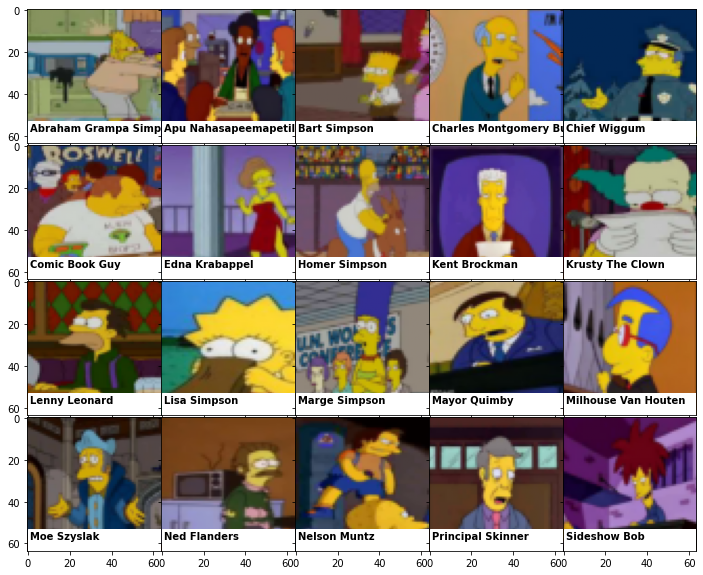

In [41]:
samples = [pick_up_random_element(elem_type,Y_train) for elem_type in range(20)]

display_samples(samples,X_train,Y_train)

## Encodage 1 parmi N

En apprentissage machine, l'encodage 1 parmi N est un groupe de bits parmi lesquels les combinaisons légales de valeurs ne sont que celles avec un seul bit haut (1) et tous les autres bas (0).

Les index représentant la position de la catégorie attribuée pour chaque personnage sont identifiés
et codés à l'aide d'un codage 1 parmi N, ce qui permet de réduire le temps de calcul machine.

In [45]:
## Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 20)
Y_test = to_categorical(Y_test, num_classes = 20)

# Réseau de neurones convolutifs 

## Définition du modèle

En traitement d'images, une **convolution** nécessite trois composantes :

- Une image d'entrée.
- Une matrice de noyau que nous allons appliquer à l'image d'entrée.
- Une image de sortie pour stocker la sortie de l'image d'entrée convoluée avec le noyau.



![](keras_conv2d_num_filters.png)

Le premier paramètre `Conv2D` requis est le nombre de filtres que la couche convolutionnelle apprendra.

Les couches au début de l'architecture du réseau (c'est-à-dire plus proches de l'image d'entrée réelle) apprennent moins de *filtres* convolutionnels tandis que les couches plus profondes du réseau (c'est-à-dire plus proches des prédictions de sortie) apprennent plus de *filtres*.

Les couches `Conv2D` intermédiaires apprendront plus de filtres que les premières couches `Conv2D`, mais moins de *filtres* que les couches plus proches de la sortie. 

J'ai choisi de définir 32 *filtres* pour les deux premières couches `Conv2D`, puis 64 *filtres* et 86 *filtres* pour les deux dernières. Chaque *filtre* transforme une partie de l'image en utilisant le *filtre* du noyau.
La matrice du *filtre* du noyau est appliquée sur l'ensemble de l'image. Les *filtres* peuvent être considérés comme une transformation de l'image.

La CNN peut isoler de ces images transformées les caractéristiques qui sont utiles partout.

La deuxième couche importante de CNN est la couche de mise en commun (`MaxPool2D`). Cette couche agit simplement comme un filtre de sous-échantillonnage. Elle examine les N pixels voisins et choisit la valeur maximale. Ces filtres sont utilisés pour réduire les coûts de calcul et, dans une certaine mesure, pour réduire le sur-échantillonnage. Nous devons choisir la taille de la mise en commun (c'est-à-dire la taille de la zone mise en commun à chaque fois) ; plus la dimension de la mise en commun est élevée, plus le sous-échantillonnage est important.


En combinant les couches convolutionnelles et les couches de regroupement, le CNN combine les caractéristiques local et les caractéristiques plus globales de l'image pour l'apprentissage.

Le *dropout* est une méthode de régularisation, où une proportion de nœuds dans la couche est ignorée de manière aléatoire (en fixant leur vision à zéro) pour chaque échantillon du jeu de donnée d'apprentissage. Cela permet de supprimer aléatoirement une partie du réseau et de forcer ce dernier à apprendre des caractéristiques de manière distribuée. Cette technique permet également d'améliorer la *généralisation* et de réduire le sur-apprentissage.

La *normalisation par lots* est une astuce technique qui permet d'accélérer l'apprentissage. Comme nous l'avons fait avec l'étape de *normalisation des images* comme étape de prétraitement pour rendre les données comparables entre elles et éviter d'observer des variations liées au différence physique des données plutôt qu'à leurs caractéritiques ciblées pour l'apprentissage. En normalisant les données dans chaque mini lot, ce problème est largement couvert.

La *couche d'aplatissement* est utilisée pour convertir les cartes de caractéristiques en un seul vecteur 1D. Cette étape d'aplatissement est nécessaire pour utiliser des couches entièrement connectées après quelques couches convolutionnelles. Elle combine toutes les caractéristiques locales trouvées dans les couches convolutives précédentes.

In [47]:
## Set the CNN model 
## my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', activation ='relu', input_shape = (64,64,3)))
model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(20, activation = "softmax"))

## Apprentissage du modèle

In [52]:
## With data augmentation to prevent the overfitting (accuracy 0.97)
    
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1, # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images
datagen.fit(X_train)

In [53]:
epochs = 60 
batch_size = 32
## Set a learning_rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

## Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size, shuffle=True),
                          epochs = epochs, validation_data = (X_test,Y_test),
                           steps_per_epoch=X_train.shape[0] // batch_size
                          , callbacks=[learning_rate_reduction, save_best])


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


# serialize model to JSON
model_json = model.to_json()
with open("results/simpsons_characters_recognition_detection", "w") as json_file:
    json_file.write(model_json)
    # serialize weights to HDF5
    #model.save_weights("model_big.h5")

NameError: name 'save_best' is not defined

## Minimisation/optimisation et recuit simulé

Une fois que nos couches sont ajoutées au modèle, nous devons mettre en place une fonction de score et un algorithme d'optimisation.

La fonction la plus importante est l'optimiseur. C'est la fonction qui va itérativement améliorer les paramètres (filtres des valeurs du noyau, poids et biais des neurones) et minimiser le score.

`RMSprop` est un optimiseur très efficace. Il comprend la méthode *Adagrad* de manière très simple pour tenter de réduire son taux d'apprentissage agressif et monotone.

Nous définissons le score pour mesurer la mauvaise performance de notre modèle sur les images dont l'étiquette est connue. Il s'agit du taux d'erreur entre les personnages obervées et les personnages assignés par le modèle.


In [48]:
## Optimizer
optimizer = RMSprop(lr=0.001, decay=1e-6)